In [1]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1.054e-34
h = hbar*2*np.pi
qe = 1.602e-19
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [3]:
# q_in, q_switch, q_out1, q_out2
EJs = [14.9, 13.91, 9.93, 13.91]
ECs = [0.237, 0.133, 0.270, 0.215]
gs = [0.0827, 0.0787, 0.0652] # g12, g23, g24

cutoffs = [4, 5, 4, 4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)


print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

qubit freqs (GHz) 5.06605616408692 3.7090309387623925 4.342501049355866 4.6655822840076855
alphas (GHz) -0.2672775380900596 -0.1453609834313605 -0.32143506007009925 -0.24195837600414905
capacitances (fF) 81.75723636114232 145.6877068991784 71.76468525033603 90.12309310507315
lumped L (nH) 10.96704080328521 11.747585044496738 16.456083380558873 11.747585044496738


In [4]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS
# qram.check_state_mapping(n=3)

In [5]:
seq = PulseSequence(start_time=0)
# wd1 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.17)
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01)
# wd3 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.08)
# wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', wd=wd1, amp=0.17)
# wd5 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.01) # should be same as wd2
# wd6 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.01)
# wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01) # should be same as wd2 and should also drive geeg -> ggeg


print('wd1')
wd1 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.20, drive_qubit=1)
# print('wd2')
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.05, drive_qubit=1)
# print('wd3')
# wd3 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.05, drive_qubit=1)
# print('wd4')
# wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.15, drive_qubit=1, wd=wd1)
# # wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.05, drive_qubit=0, wd=wd1)
# print('wd5')
# wd5 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.05, drive_qubit=1)
# print('wd6')
# wd6 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.15, drive_qubit=1)
# print('wd7')
# wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.05, drive_qubit=1)

wd1
	new overlap 0.715853493282021 wd 13.62988736555096 wd_res 0.25
	new overlap 0.715853493282021 wd 13.62988736555096 wd_res 0.05
	new overlap 0.9829816159629167 wd 13.60988736555096 wd_res 0.005
	new overlap 0.9829816159629168 wd 13.60988736555096 wd_res 0.001
	new overlap 0.9832174746096431 wd 13.610287365550962 wd_res 0.0002
	new overlap 0.9832320926465911 wd 13.610207365550961 wd_res 4e-05
	new overlap 0.9832320926465911 wd 13.610207365550961 wd_res 8.000000000000001e-06
updated drive freq (GHz) from 2.1692639480132065 to 2.166131778733158


In [6]:
# CHECK FOR CLASHING LEVELS
tolerance = 100*MHz
problem_pulses = qram.check_level_resonances(seq, tolerance=tolerance)
good_freqs = seq.get_pulse_freqs(simplified=True)
print(good_freqs)
if len(problem_pulses.items()) == 0:
    print(f'No clashes found within {tolerance} GHz!')
for good_pulse, problem_pulse_dict in problem_pulses.items():
    print('Clashes to', tolerance,'GHz with', good_pulse[0], '<->', good_pulse[1], f'(freq = {good_freqs[good_pulse]})', 'tpi', qram.get_Tpi(good_pulse[0], good_pulse[1], amp=0.05))
    for problem_pulse, freq in problem_pulse_dict.items():
        diff_freq = np.abs(freq)-np.abs(good_freqs[good_pulse])
        if np.abs(diff_freq) > tolerance:
            diff_freq = 2*np.abs(freq)-np.abs(good_freqs[good_pulse])
        print('\t', 'GOOD PULSE' if problem_pulse in good_freqs.keys() else '', problem_pulse[0], '<->', problem_pulse[1], freq, f'(off by {diff_freq*1e3} MHz)', 'tpi', qram.get_Tpi(problem_pulse[0], problem_pulse[1], amp=0.05))

{('eggg', 'gfgg'): 2.166131778733158}
No clashes found within 0.1 GHz!


[2.166131778733158] (GHz)
[309.25868462042916] (ns)
total pulse length 309.25868462042916 ns


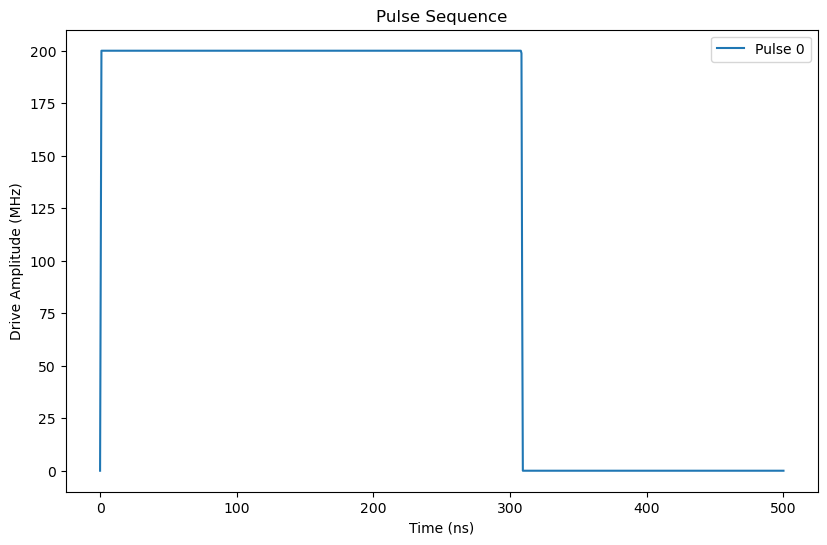

In [7]:
times = np.linspace(0, 500, 1000)
# times = np.linspace(0, 750, 1000)
# times = np.linspace(0, 300, 700)
# times = np.linspace(0, 50, 100)

envelope_seq = seq.get_envelope_seq()
print(seq.get_pulse_freqs(), '(GHz)')
print(seq.get_pulse_lengths(), '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
for i in range(len(envelope_seq)):
    plt.plot(times, [envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

In [8]:
T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

# c_ops = [
#     np.sqrt(1/T1)*qram.a,
#     np.sqrt(1/T1)*qram.b,
#     np.sqrt(1/T1)*qram.c,
#     np.sqrt(1/T1)*qram.d,
# ]

c_ops = None

In [9]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = np.sqrt(0.4) * qram.state('eggg') + np.sqrt(0.6) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.4) * qram.state('gggg') + np.sqrt(0.6) * qram.state('gegg') # QRAM start

# print(seq.get_pulse_str())

# result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=1000)
result = qram.evolve_rot_frame(psi0, seq, times, c_ops=None, nsteps=10000)

10.0%. Run time:   0.62s. Est. time left: 00:00:00:05
20.0%. Run time:   1.48s. Est. time left: 00:00:00:05
30.0%. Run time:   2.32s. Est. time left: 00:00:00:05
40.0%. Run time:   3.38s. Est. time left: 00:00:00:05
50.0%. Run time:   4.41s. Est. time left: 00:00:00:04
60.0%. Run time:   5.49s. Est. time left: 00:00:00:03
70.0%. Run time:   6.37s. Est. time left: 00:00:00:02
80.0%. Run time:   7.25s. Est. time left: 00:00:00:01
90.0%. Run time:   8.17s. Est. time left: 00:00:00:00
Total run time:   9.06s


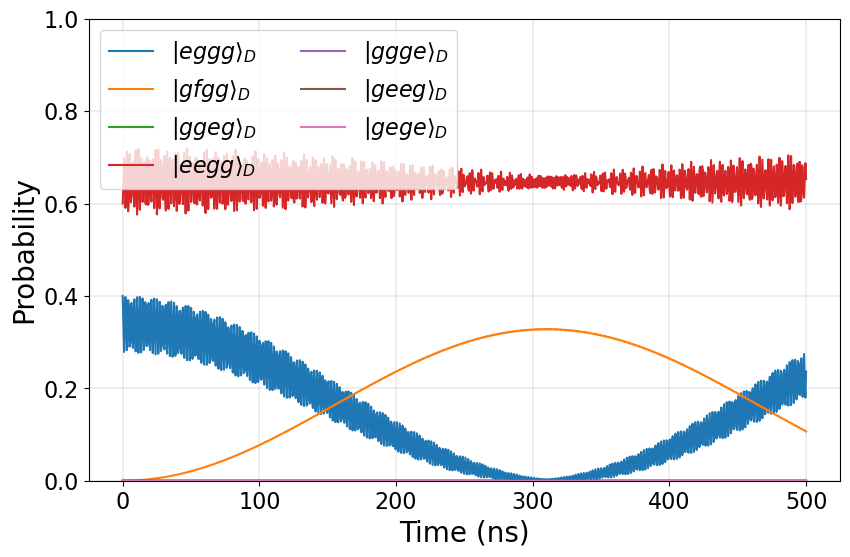

In [10]:
# states for 1 input
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')
geeg = qram.state('geeg')
gege = qram.state('gege')
prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]
prob_geeg = [np.abs(geeg.overlap(result[t]))**2 for t in range(len(times))]
prob_gege = [np.abs(gege.overlap(result[t]))**2 for t in range(len(times))]

# states for 0 input
gggg = qram.state('gggg')
gegg = qram.state('gegg')
prob_gggg = [np.abs(gggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gegg = [np.abs(gegg.overlap(result[t]))**2 for t in range(len(times))]


plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')
plt.plot(times, prob_geeg, label=r'$|geeg\rangle_D$')
plt.plot(times, prob_gege, label=r'$|gege\rangle_D$')

# plt.plot(times, prob_gggg, label=r'$|gggg\rangle_D$')
# plt.plot(times, prob_gegg, label=r'$|gegg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=16)
plt.xlabel('Time (ns)', fontsize=20)
plt.ylabel('Probability', fontsize=20)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

In [11]:
T = 30 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
probs = dict()
print("Non-zero levels:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                sum_psi += prob
                if prob > 0.01:
                    probs.update({qram.level_nums_to_name([i1, i2, i3, i4]):prob})
probs = sorted(probs.items(), key=lambda item:-item[1])
for level, prob in probs:
    print(level, prob)
print('Sum probabilities:', sum_psi)

Non-zero levels:
eegg 0.6762881797915464
eggg 0.2900291384679592
efgg 0.025614481197614492
Sum probabilities: 0.9999999999999999


In [12]:
print('want', qram.get_base_wd('eggg', 'gfgg')/2/np.pi)
print('want', qram.get_base_wd('eegg', 'eggg')/2/np.pi)
# print('want', qram.get_wd('eggg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('eegg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('ggge', 'gege', 0.05, verbose=False)/2/np.pi)
# print('resonant to', qram.get_wd('ggeg', 'geeg', 0.05)/2/np.pi)
# print('2 photon transition to', qram.get_base_wd('eggg', 'efgg')/2/np.pi)

want 2.1692639480132065
want 3.6869102975757024
